In [4]:
import pandas as pd
import numpy as np
from langdetect import detect as langdetect
import random
seed = 42
np.random.seed(seed)
random.seed(seed)
import sys
sys.path.append("..")
from data.labeled import CWA as cwa, CWR as cwr,LABELED_DIR

# Preprocess whole dataset

In [5]:
cwa.head()

,Account No,Organisation,City,Country,Region,Access,C40,Reporting Year,Risks to city's water supply,Adaptation action,Action description,City Location
0,1093,City of Atlanta,Atlanta,United States of America,North America,public,NaN,2018,Increased water stress or scarcity,Investment in existing water supply infrastruc...,"The city is building a new reservoir, fixing t...","(33.749, -84.388)"
1,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Conservation awareness and education,NaN,"(30.2672, -97.7431)"
2,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Conservation incentives,NaN,"(30.2672, -97.7431)"
3,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Water use restrictions,NaN,"(30.2672, -97.7431)"
4,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Efficiency regulations or standards,NaN,"(30.2672, -97.7431)"


In [6]:
cwr.head()

,Account No,Organisation,City,Country,Region,Access,C40,Reporting year,Risks to city's water supply,Timescale,Magnitude,Risk description,Current population,Population year,City Location
0,1093,City of Atlanta,Atlanta,United States of America,North America,public,NaN,2018,Increased water stress or scarcity,Short-term,Serious,The city depends on one river for water supply...,450182.0,2017,"(33.749, -84.388)"
1,1093,City of Atlanta,Atlanta,United States of America,North America,public,NaN,2018,Higher water prices,Current,Serious,The water cost burden is felt across all ZIP c...,450182.0,2017,"(33.749, -84.388)"
2,1184,City of Austin,Austin,United States of America,North America,public,C40,2018,Increased water stress or scarcity,Medium-term,Extremely serious,NaN,1265974.0,2017,"(30.2672, -97.7431)"
3,1499,Ajuntament de Barcelona,Barcelona,Spain,Europe,public,C40,2018,Increased water stress or scarcity,Current,Extremely serious,The downscaling of the climate projections at ...,1604555.0,2015,"(41.3823, 2.1775)"
4,1499,Ajuntament de Barcelona,Barcelona,Spain,Europe,public,C40,2018,Declining water quality,Medium-term,Serious,A reduction in water resources availability c...,1604555.0,2015,"(41.3823, 2.1775)"


## Normalize columns names

In [7]:
# Convert columns names to lowercase
cwa.columns = cwa.columns.str.lower().str.replace(" ", "_").str.replace("'","")
cwr.columns = cwr.columns.str.lower().str.replace(" ", "_").str.replace("'","")

## Find counts of nulls per column

In [8]:
cwr.isnull().sum()

account_no                       0
organisation                     0
city                             0
country                          0
region                           0
access                           0
c40                            504
reporting_year                   0
risks_to_citys_water_supply     40
timescale                       11
magnitude                      159
risk_description               107
current_population               0
population_year                  0
city_location                    0
dtype: int64

In [9]:
cwa.isnull().sum()

account_no                       0
organisation                     0
city                             0
country                          0
region                           0
access                           0
c40                            536
reporting_year                   0
risks_to_citys_water_supply     75
adaptation_action               19
action_description             146
city_location                    0
dtype: int64

## Find columns that exist in both datasets

In [10]:
id_columns = list(set(cwr.columns) & set(cwa.columns))
id_columns

['access',
 'country',
 'city',
 'c40',
 'organisation',
 'city_location',
 'account_no',
 'reporting_year',
 'region',
 'risks_to_citys_water_supply']

## Check how many nulls exist in these columns

In [11]:
cwr[id_columns].isnull().sum()

access                           0
country                          0
city                             0
c40                            504
organisation                     0
city_location                    0
account_no                       0
reporting_year                   0
region                           0
risks_to_citys_water_supply     40
dtype: int64

In [12]:
cwa[id_columns].isnull().sum()

access                           0
country                          0
city                             0
c40                            536
organisation                     0
city_location                    0
account_no                       0
reporting_year                   0
region                           0
risks_to_citys_water_supply     75
dtype: int64

## Replace nulls there with "nan" strings, so that merging is done correctly

In [13]:
cwr['c40'] = cwr['c40'] == 'C40'
cwr[id_columns] = cwr[id_columns].fillna('nan')

In [14]:
cwa['c40'] = cwa['c40'] == 'C40'
cwa[id_columns] = cwa[id_columns].fillna('nan')

## Check id_columns uniqueness

In [15]:
len(cwa[id_columns]), len(cwa[id_columns].drop_duplicates())


(685, 484)

In [16]:
len(cwr[id_columns]), len(cwr[id_columns].drop_duplicates())

(608, 578)

## Aggregate by grouping by id_columns and applying set operations to other colums

In [17]:
cwa_agg = cwa.groupby(id_columns).agg(set).reset_index()
cwr_agg = cwr.groupby(id_columns).agg(set).reset_index()

## Make sure that risks magnitude (which is going to be used as an entry label) has a single value 

In [18]:
cwr_agg.magnitude = cwr_agg.magnitude.apply(lambda x: 'Extremely serious' if 'Extremely serious' in x  else ('Serious' if 'Serious' in x else list(x)[0]))

In [19]:
cwr_agg.magnitude.unique()

array(['Less Serious', 'Extremely serious', 'Serious', nan], dtype=object)

## Merge (outer) datasets and find the columns that are set (list_columns)
filling the non-merged rows with {np.nan} on list_columns to make sure there is contingency in each column

In [20]:
cw_data = pd.merge(cwa_agg, cwr_agg, on=id_columns, how='outer')
list_columns = cw_data.iloc[0].apply(lambda x: isinstance(x, set))
list_columns = list_columns[list_columns].index
cw_data[list_columns] = cw_data[list_columns].applymap(lambda x: {np.nan} if pd.isna(x) else x)

In [21]:
cw_data.head()

,access,country,city,c40,organisation,city_location,account_no,reporting_year,region,risks_to_citys_water_supply,adaptation_action,action_description,timescale,magnitude,risk_description,current_population,population_year
0,public,Argentina,CÃ³rdoba,False,Municipalidad de CÃ³rdoba,"(-31.4201, -64.1888)",50371,2018,Latin America,Increased water stress or scarcity,{Conservation awareness and education},{Se realizan campaÃ±as en Ã©poca estival a fin...,{Short-term},Less Serious,{Existe la probabilidad que en el corto plazo ...,{1430000.0},{2017}
1,public,Argentina,"General Alvear, Buenos Aires",False,Municipalidad de General Alvear (Mendoza),"(-34.978, -67.6955)",69834,2018,Latin America,Declining water quality,{Water use restrictions},{La Ley de Aguas Provincial define como priori...,{Long-term},Extremely serious,{El riesgo potencial que corre la alta cueca e...,{46429.0},{2010}
2,public,Argentina,"General Alvear, Buenos Aires",False,Municipalidad de General Alvear (Mendoza),"(-34.978, -67.6955)",69834,2018,Latin America,Inadequate or aging infrastructure,{Investment in existing water supply infrastru...,{Encauzamiento del RÃ­o Atuel: esta obra se re...,{nan},NaN,{nan},{nan},{nan}
3,public,Argentina,"General Alvear, Buenos Aires",False,Municipalidad de General Alvear (Mendoza),"(-34.978, -67.6955)",69834,2018,Latin America,Increased water stress or scarcity,{Investment in existing water supply infrastru...,{Aguas Mendocinas en cuanto a agua potable est...,{Current},Extremely serious,{Los rÃ­os Atuel y Diamante aportan sus aguas ...,{46429.0},{2010}
4,public,Argentina,Mendoza,False,Ciudad de Mendoza,"(-32.8894, -68.8458)",50357,2018,Latin America,Inadequate or aging infrastructure,{Water use restrictions},{Horario de restricciÃ³n establecido para el ...,{nan},NaN,{nan},{nan},{nan}


## Extract longitude and latitude from city_location

In [22]:
cw_data['city_location'] = cw_data['city_location'].apply(eval)
cw_data['latitude'] = cw_data['city_location'].apply(lambda x: x[0])
cw_data['longitude'] = cw_data['city_location'].apply(lambda x: x[1])
id_columns = [x for x in id_columns] + ['latitude','longitude']


## Find list columns that are singular (every element contains a length 1 list)

In [23]:
cw_value_columns = [ x for x in cw_data.columns if x not in id_columns]
# Values that can be converted back to strings from sets

singular_cols = cw_data.set_index(id_columns)[list_columns].applymap(lambda x: len(x)==1).product() > 0
singular_cols

adaptation_action     False
action_description    False
timescale             False
risk_description      False
current_population     True
population_year        True
dtype: bool

## Convert singular columns to non list ones

In [24]:
# magnitude is nicely singular per id
cw_data.loc[:, singular_cols[singular_cols].index] = cw_data.loc[:, singular_cols[singular_cols].index].applymap(lambda x: list(x)[0])
list_columns = [x for x in list_columns if x not in singular_cols[singular_cols].index]

## Remove entries that are invalid or in different language than English from the list columns
**also convert sets to lists**

In [25]:
def try_lang_detect_except(x):
    try:
        return (langdetect(x)=='en')
    except:
        return False
cw_data = cw_data.applymap(lambda x: [t for t in x if not pd.isnull(t)  and  (t!='') and (t!='ERROR: #NAME?') and try_lang_detect_except(t)] if isinstance(x,set) else x)

## Fix specific risks annotations by inspection

In [26]:
cw_data.risks_to_citys_water_supply.unique()

array(['Increased water stress or scarcity', 'Declining water quality',
       'Inadequate or aging infrastructure', 'Higher water prices',
       'Regulatory', 'Increased water demand', 'nan',
       'Energy supply issues', 'Inadequate or ageing infrastructure',
       'Declining water quality: Declining water quality'], dtype=object)

In [27]:
cw_data.risks_to_citys_water_supply = cw_data.risks_to_citys_water_supply.apply(lambda x: x.replace('Inadequate or ageing infrastructure','Inadequate or aging infrastructure'))
cw_data['risks_to_citys_water_supply'] = cw_data['risks_to_citys_water_supply'].apply(lambda x: x.replace('Declining water quality: Declining water quality', 'Declining water quality'))
cw_data.risks_to_citys_water_supply.unique()

array(['Increased water stress or scarcity', 'Declining water quality',
       'Inadequate or aging infrastructure', 'Higher water prices',
       'Regulatory', 'Increased water demand', 'nan',
       'Energy supply issues'], dtype=object)

In [28]:
cw_data.head()

,access,country,city,c40,organisation,city_location,account_no,reporting_year,region,risks_to_citys_water_supply,adaptation_action,action_description,timescale,magnitude,risk_description,current_population,population_year,latitude,longitude
0,public,Argentina,CÃ³rdoba,False,Municipalidad de CÃ³rdoba,"(-31.4201, -64.1888)",50371,2018,Latin America,Increased water stress or scarcity,[Conservation awareness and education],[],[Short-term],Less Serious,[],1430000.0,2017.0,-31.4201,-64.1888
1,public,Argentina,"General Alvear, Buenos Aires",False,Municipalidad de General Alvear (Mendoza),"(-34.978, -67.6955)",69834,2018,Latin America,Declining water quality,[Water use restrictions],[],[Long-term],Extremely serious,[],46429.0,2010.0,-34.9780,-67.6955
2,public,Argentina,"General Alvear, Buenos Aires",False,Municipalidad de General Alvear (Mendoza),"(-34.978, -67.6955)",69834,2018,Latin America,Inadequate or aging infrastructure,[Investment in existing water supply infrastru...,[],[],NaN,[],NaN,NaN,-34.9780,-67.6955
3,public,Argentina,"General Alvear, Buenos Aires",False,Municipalidad de General Alvear (Mendoza),"(-34.978, -67.6955)",69834,2018,Latin America,Increased water stress or scarcity,[Investment in existing water supply infrastru...,[],[],Extremely serious,[],46429.0,2010.0,-34.9780,-67.6955
4,public,Argentina,Mendoza,False,Ciudad de Mendoza,"(-32.8894, -68.8458)",50357,2018,Latin America,Inadequate or aging infrastructure,[Water use restrictions],[],[],NaN,[],NaN,NaN,-32.8894,-68.8458


## Drop metadata columns that will not be used

In [29]:
to_drop = ['timescale','current_population','population_year']
cw_data.drop(columns=['timescale','current_population','population_year'],inplace=True)

## Generate for each of the  list columns a new one that contains the number of elements
**Create value_columns that contains the names of all the list columns + the created ones**

In [30]:
value_columns = set([x for x in cw_value_columns if x not in to_drop] + ['risks_to_citys_water_supply'])
list_columns = cw_data.iloc[0].apply(lambda x: isinstance(x, list))
list_columns = list_columns[list_columns].index
len_columns = set()
for x in value_columns.copy():
    if x in list_columns:
        cw_data[x+'_n'] = cw_data[x].apply(lambda x: len(x) if x else 1)
        len_columns.add(x+'_n')
value_columns = value_columns.union(len_columns)
value_columns

{'action_description',
 'action_description_n',
 'adaptation_action',
 'adaptation_action_n',
 'magnitude',
 'risk_description',
 'risk_description_n',
 'risks_to_citys_water_supply'}

# Filter by C40
**We are making the assumption that, given that those cities participate in a specific program, they will also have better structured data. So this subset will be used as a reference for the imputation**

In [31]:
c40_data = cw_data[cw_data['c40']].copy()
c40_data.shape

(112, 19)

## Find the null percentage of list columns

In [32]:
list_nulls = c40_data[list_columns].applymap(lambda x: len(x) == 0)
list_nulls.mean()

adaptation_action     0.366071
action_description    0.464286
risk_description      0.357143
dtype: float64

In [33]:
c40_data['magnitude'].unique()

array(['Serious', nan, 'Less Serious', 'Extremely serious'], dtype=object)

## Create a report of the values of magnitude

In [34]:
c40_risks = c40_data[id_columns+['magnitude']].copy()
c40_risks['low'] = c40_risks['magnitude'] == 'Less Serious'
c40_risks['medium'] = c40_risks['magnitude'] == 'Serious'
c40_risks['high'] = c40_risks['magnitude'] == 'Extremely serious'
c40_risks['unknown'] = c40_risks['magnitude'].isna()
c40_risks = c40_risks.drop(columns=['magnitude']).groupby([x for x in id_columns if x!="risks_to_citys_water_supply"]).agg(sum).reset_index()
c40_risks

,access,country,city,c40,organisation,city_location,account_no,reporting_year,region,latitude,longitude,low,medium,high,unknown
0,public,Australia,City of Melbourne,True,City of Melbourne,"(-37.8141, 144.963)",31109,2018,Southeast Asia and Oceania,-37.81410,144.96300,0,2,0,0
1,public,Australia,City of Sydney,True,City of Sydney,"(-33.8675, 151.207)",31114,2018,Southeast Asia and Oceania,-33.86750,151.20700,0,5,0,1
2,public,Bangladesh,Dhaka,True,Dhaka City,"(23.8103, 90.4125)",50782,2018,South and West Asia,23.81030,90.41250,0,0,0,5
3,public,Brazil,Curitiba,True,Municipality of Curitiba,"(-25.4311, -49.2647)",31156,2018,Latin America,-25.43110,-49.26470,1,0,0,0
4,public,Brazil,Rio de Janeiro,True,Prefeitura do Rio de Janeiro,"(-22.9054, -43.5614)",31176,2018,Latin America,-22.90540,-43.56140,0,2,1,1
5,public,Brazil,SÃ£o Paulo,True,Prefeitura de SÃ£o Paulo,"(-23.5595, -46.7382)",31184,2018,Latin America,-23.55950,-46.73820,0,1,0,0
6,public,Canada,Vancouver,True,City of Vancouver,"(49.2612, -123.114)",20113,2018,North America,49.26120,-123.11400,1,0,0,0
7,public,Chile,Santiago,True,RegiÃ³n Metropolitana de Santiago,"(-33.4489, -70.6693)",31180,2018,Latin America,-33.44890,-70.66930,0,3,0,0
8,public,China,Dalian,True,Dalian Municipal People's Government,"(38.9389, 121.567)",54298,2018,East Asia,38.93890,121.56700,0,0,0,2
9,public,"China, Hong Kong Special Administrative Region",Hong Kong,True,Government of Hong Kong Special Administrative...,"(22.2881, 114.14)",31169,2018,East Asia,22.28810,114.14000,1,1,0,1


In [35]:
from sklearn.preprocessing import LabelEncoder

In [36]:
from utils.nlp import SimilarityAnalysis, create_sim_vector

In [37]:
c40_data.risks_to_citys_water_supply = c40_data.risks_to_citys_water_supply.apply(lambda x: np.nan if x=='nan' else x)

In [38]:
c40_data[c40_data.risks_to_citys_water_supply.isnull()]

,access,country,city,c40,organisation,city_location,account_no,reporting_year,region,risks_to_citys_water_supply,adaptation_action,action_description,magnitude,risk_description,latitude,longitude,action_description_n,risk_description_n,adaptation_action_n
19,public,Bangladesh,Dhaka,True,Dhaka City,"(23.8103, 90.4125)",50782,2018,South and West Asia,NaN,[Stormwater management (natural or man-made in...,[Embankment is constructed around Dhaka City t...,NaN,[Increases water born diseases],23.8103,90.4125,1,1,1
163,public,India,Kolkata,True,Kolkata Metropolitan Area,"(22.5726, 88.3639)",35904,2018,South and West Asia,NaN,[Stormwater management (natural or man-made in...,[Complete restriction in use of Ground water. ...,NaN,[Kolkata is currently ranked as the third most...,22.5726,88.3639,2,2,2
168,public,Indonesia,Jakarta,True,Jakarta City Government,"(-6.1751, 106.865)",31166,2018,Southeast Asia and Oceania,NaN,[Other: Stormwater management (natural or man ...,[- Restore damaged and lost water ecosystems (...,NaN,[Increased frequency of rain affecting the are...,-6.1751,106.8650,1,1,1
183,public,Japan,Tokyo,True,Tokyo Metropolitan Government,"(35.41, 139.41)",31111,2018,East Asia,NaN,[],[Implementing measures against flood],Serious,[],35.4100,139.4100,1,1,1
269,public,Norway,Oslo,True,City of Oslo,"(59.9139, 10.7522)",14088,2018,Europe,NaN,[Investment in existing water supply infrastru...,[Small scale project to implement water meeter...,NaN,[],59.9139,10.7522,4,1,3
303,public,South Africa,Johannesburg,True,City of Johannesburg,"(-26.2041, 28.0473)",31115,2018,Africa,NaN,[Water use restrictions],[A by-law that effects water restrictions is i...,NaN,[],-26.2041,28.0473,1,1,1
443,public,United States of America,"Portland, OR",True,"City of Portland, OR","(45.52, -122.682)",14874,2018,North America,NaN,[Watershed preservation],[Portland seeks to manage the watershed in way...,NaN,"[Portland has a secondary, redundant, groundwa...",45.5200,-122.6820,1,1,1


In [39]:
c40_data.risks_to_citys_water_supply.unique()

array(['Increased water demand', 'Increased water stress or scarcity',
       'Inadequate or aging infrastructure', 'Declining water quality',
       nan, 'Higher water prices', 'Energy supply issues', 'Regulatory'],
      dtype=object)

## Fit Similarity Analysis
**per string list column of the value columns, by concatenating strings together. Vectorize all the string list columns based on their in between similarities**


In [40]:
analyses = {x:SimilarityAnalysis() for x in value_columns if x in list_columns}

In [41]:
vectorized = np.hstack([analyses[x].fit_transform(c40_data[x]) for x in analyses])

## Encode magnitude and risks into numerical labels

In [42]:
cols_to_encode =  [x for x in value_columns if x not in list_columns and x not in len_columns]
c40_data[cols_to_encode] = c40_data[cols_to_encode].fillna('nan')
encoders = {x:LabelEncoder().fit(c40_data[x].fillna('nan')) for x in cols_to_encode}

In [43]:
encoded = np.array([encoders[x].transform(c40_data[x]) for x in encoders]).T.astype(float)
for t in range(len(cols_to_encode)):
    encoded[encoded[:,t] == np.where(encoders[cols_to_encode[t]].classes_=='nan')[0]] = np.nan

In [44]:
lab_freqs = c40_data[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
lab_freqs

,magnitude,risks_to_citys_water_supply,size
0,Extremely serious,Energy supply issues,1
1,Extremely serious,Higher water prices,1
2,Extremely serious,Inadequate or aging infrastructure,3
3,Extremely serious,Increased water demand,1
4,Extremely serious,Increased water stress or scarcity,8
5,Less Serious,Declining water quality,2
6,Less Serious,Higher water prices,1
7,Less Serious,Inadequate or aging infrastructure,2
8,Less Serious,Increased water demand,1
9,Less Serious,Increased water stress or scarcity,3


## Create dataset that contains the encoded labels, the vectorized columns and the columns referring the lists lengths

In [45]:
whole = np.hstack([encoded, vectorized, c40_data[len_columns]])

In [46]:
import sys
sys.path.append('..')
from labeled_preprocessing.imputation import LabeledDatasetImputer

## Fit LabeledDatasetImputer and transform dataset
**(LabeledDatasetImputer is a union of two Iterative Imputers , one for labels and one for features)**

In [47]:
imputer = LabeledDatasetImputer(verbose=2,k_features_per_label=0, seed=seed)
continuous_imputed, y = imputer.fit_transform(whole[:,2:], whole[:,:2], ret_imputed_x=True)

Applying feature selection..
Creating imputed X using KNeighborsRegressor..
[IterativeImputer] Completing matrix with shape (112, 206)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.76
[IterativeImputer] Change: 17.311409692111734, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 2/10, elapsed time 1.46
[IterativeImputer] Change: 11.0570776829301, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 3/10, elapsed time 2.29
[IterativeImputer] Change: 3.4138798918123863, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 4/10, elapsed time 3.08
[IterativeImputer] Change: 0.8454854397545399, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 5/10, elapsed time 3.85
[IterativeImputer] Change: 1.0342516913179425, scaled tolerance: 0.011 
[IterativeImputer] Ending imputation round 6/10, elapsed time 4.98
[IterativeImputer] Change: 0.540563145979053, scaled tolerance: 0.011 
[IterativeImputer] Ending imputati

## Use the prediction power on the imputed data as measurement of coherent imputation.

In [48]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
simple_model = make_pipeline(StandardScaler(), SVC(kernel='linear', C=0.01, random_state=seed))
scoring = 'accuracy' 
scores = cross_val_score(simple_model, continuous_imputed, y[:,cols_to_encode.index('magnitude')], cv=5,scoring=scoring)
np.mean(scores)

0.7498023715415021

## Plot features correlation

(208, 208)


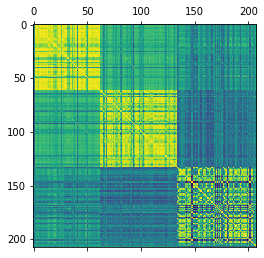

In [49]:
import matplotlib.pyplot as plt
flg = np.all(~np.isnan(whole),axis=1), np.hstack([[True, True], imputer.selection_mask[:]])
corr = np.corrcoef(whole[flg[0],:][:,flg[1]].T)
print(corr.shape)
plt.matshow(corr)

## Retrieve the categorical imputed labels

In [50]:
imputed = np.array([
    encoders[x].inverse_transform(
    y[:, c].astype(int)
 ) for c,x in enumerate(cols_to_encode)]).T

In [51]:
c40_data_imputed = c40_data.copy()

In [52]:
c40_data_imputed[cols_to_encode] = imputed

In [53]:
c40_data_imputed.head()

,access,country,city,c40,organisation,city_location,account_no,reporting_year,region,risks_to_citys_water_supply,adaptation_action,action_description,magnitude,risk_description,latitude,longitude,action_description_n,risk_description_n,adaptation_action_n
10,public,Australia,City of Melbourne,True,City of Melbourne,"(-37.8141, 144.963)",31109,2018,Southeast Asia and Oceania,Increased water demand,[Conservation awareness and education],[],Serious,[Melbourne Water analysed the effect of greate...,-37.8141,144.9630,1,1,1
11,public,Australia,City of Melbourne,True,City of Melbourne,"(-37.8141, 144.963)",31109,2018,Southeast Asia and Oceania,Increased water stress or scarcity,[Efficiency regulations or standards],[],Serious,[Melbourne Water analysed the effect of greate...,-37.8141,144.9630,1,1,1
12,public,Australia,City of Sydney,True,City of Sydney,"(-33.8675, 151.207)",31114,2018,Southeast Asia and Oceania,Increased water stress or scarcity,"[Municipal water efficiency retrofits, Stormwa...","[In NSW, local councils are responsible for ma...",Serious,[],-33.8675,151.2070,2,1,2
13,public,Australia,City of Sydney,True,City of Sydney,"(-33.8675, 151.207)",31114,2018,Southeast Asia and Oceania,Increased water stress or scarcity,[Diversifying water supply (including new sour...,[The City is investing in a number of actions ...,Serious,"[Securing water to support healthy, resilient ...",-33.8675,151.2070,1,1,1
16,public,Bangladesh,Dhaka,True,Dhaka City,"(23.8103, 90.4125)",50782,2018,South and West Asia,Inadequate or aging infrastructure,[],[],Serious,[],23.8103,90.4125,1,1,1


## Find which labels  have been updated after imputation

In [54]:
imp_lab_freqs = c40_data_imputed[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
imp_ret = pd.merge(lab_freqs, imp_lab_freqs,suffixes=('','_imp'), how='right',on=cols_to_encode)
imp_ret['increase'] = (imp_ret['size_imp'] - imp_ret['size'])/imp_ret['size']
imp_ret

,magnitude,risks_to_citys_water_supply,size,size_imp,increase
0,Extremely serious,Energy supply issues,1,1,0.000000
1,Extremely serious,Higher water prices,1,1,0.000000
2,Extremely serious,Inadequate or aging infrastructure,3,3,0.000000
3,Extremely serious,Increased water demand,1,1,0.000000
4,Extremely serious,Increased water stress or scarcity,8,13,0.625000
5,Less Serious,Declining water quality,2,2,0.000000
6,Less Serious,Higher water prices,1,1,0.000000
7,Less Serious,Inadequate or aging infrastructure,2,2,0.000000
8,Less Serious,Increased water demand,1,1,0.000000
9,Less Serious,Increased water stress or scarcity,3,3,0.000000


## Make sure that all risks have been encoded and are imputation outcome candidates 

In [55]:
set([x for x in cw_data['risks_to_citys_water_supply'] if x not in encoders['risks_to_citys_water_supply'].classes_])

set()

# Impute whole dataset

In [56]:
cw_data['risks_to_citys_water_supply'].value_counts()

Increased water stress or scarcity    205
Inadequate or aging infrastructure    180
Declining water quality               127
nan                                    54
Increased water demand                 49
Higher water prices                    38
Regulatory                             17
Energy supply issues                    7
Name: risks_to_citys_water_supply, dtype: int64

## Apply encoding and vectorization
**based on fitted encoders and SimilarityAnalysis objects**

In [57]:
cw_data[cols_to_encode] = cw_data[cols_to_encode].fillna('nan')
encoded = np.array([encoders[x].transform(cw_data[x]) for x in encoders]).T.astype(float)
for t in range(len(cols_to_encode)):
    encoded[encoded[:,t] == np.where(encoders[cols_to_encode[t]].classes_=='nan')[0]] = np.nan

In [58]:
all_vectorized = np.hstack([analyses[x].transform(cw_data[x]) for x in value_columns if x in list_columns])

## Apply imputation
**using the trained imputer**

In [59]:
all_imputed_x, all_imputed_y  = imputer.transform(np.hstack([all_vectorized,cw_data[len_columns]]), encoded, ret_imputed_x=True)

[IterativeImputer] Completing matrix with shape (677, 206)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.76
[IterativeImputer] Ending imputation round 2/10, elapsed time 1.33
[IterativeImputer] Ending imputation round 3/10, elapsed time 1.93
[IterativeImputer] Ending imputation round 4/10, elapsed time 2.72
[IterativeImputer] Ending imputation round 5/10, elapsed time 3.82
[IterativeImputer] Ending imputation round 6/10, elapsed time 4.72
[IterativeImputer] Ending imputation round 7/10, elapsed time 5.53
[IterativeImputer] Ending imputation round 8/10, elapsed time 6.26
[IterativeImputer] Ending imputation round 9/10, elapsed time 6.98
[IterativeImputer] Ending imputation round 10/10, elapsed time 7.74
[IterativeImputer] Completing matrix with shape (677, 208)
[IterativeImputer] Ending imputation round 1/2, elapsed time 0.02
[IterativeImputer] Ending imputation round 2/2, elapsed time 0.05


In [60]:
all_imputed_y_dec = np.array([
    encoders[x].inverse_transform(
    all_imputed_y[:, c].astype(int)
 ) for c,x in enumerate(cols_to_encode)]).T

In [61]:
cw_data_imputed = cw_data.copy()
cw_data_imputed[cols_to_encode] = all_imputed_y_dec

## Plot features correlation

(208, 208)


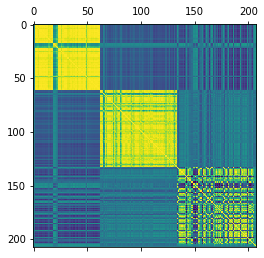

In [62]:
import matplotlib.pyplot as plt
corr = np.corrcoef(np.hstack([all_imputed_y, all_imputed_x]).T)
print(corr.shape)
plt.matshow(corr)

In [63]:
scores = cross_val_score(simple_model, all_imputed_x, all_imputed_y[:,cols_to_encode.index('magnitude')], cv=5,scoring=scoring)
np.mean(scores)

0.7134422657952071

**The score did not have significant drop, so we can assume that the imputation was cohesive across data**

## Create output dataset

In [64]:
final_labeled_data = cw_data_imputed[['city','latitude','longitude','country','c40','region','magnitude','risks_to_citys_water_supply']].copy()
final_labeled_data.rename(columns={'magnitude': 'risk','risks_to_citys_water_supply': 'description'},inplace=True)
final_labeled_data.to_csv(os.path.join(LABELED_DIR, "labeled_cities.csv"),index=False)

In [65]:
final_labeled_data

,city,latitude,longitude,country,c40,region,risk,description
0,CÃ³rdoba,-31.4201,-64.1888,Argentina,False,Latin America,Less Serious,Increased water stress or scarcity
1,"General Alvear, Buenos Aires",-34.9780,-67.6955,Argentina,False,Latin America,Extremely serious,Declining water quality
2,"General Alvear, Buenos Aires",-34.9780,-67.6955,Argentina,False,Latin America,Serious,Inadequate or aging infrastructure
3,"General Alvear, Buenos Aires",-34.9780,-67.6955,Argentina,False,Latin America,Extremely serious,Increased water stress or scarcity
4,Mendoza,-32.8894,-68.8458,Argentina,False,Latin America,Serious,Increased water stress or scarcity
...,...,...,...,...,...,...,...,...
672,Ho Chi Minh,10.7626,106.6600,Viet Nam,True,Southeast Asia and Oceania,Serious,Declining water quality
673,Ho Chi Minh,10.7626,106.6600,Viet Nam,True,Southeast Asia and Oceania,Less Serious,Higher water prices
674,Ho Chi Minh,10.7626,106.6600,Viet Nam,True,Southeast Asia and Oceania,Less Serious,Inadequate or aging infrastructure
675,Ho Chi Minh,10.7626,106.6600,Viet Nam,True,Southeast Asia and Oceania,Less Serious,Increased water demand


## See a report of the filled labels

In [66]:
cw_lab_freqs = cw_data[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
imp_cw_lab_freqs = cw_data_imputed[cols_to_encode].groupby(cols_to_encode,as_index=False).size()
imp_cw_ret = pd.merge(cw_lab_freqs, imp_cw_lab_freqs,suffixes=('','_imp'), how='right',on=cols_to_encode)
imp_cw_ret['increase'] = (imp_cw_ret['size_imp'] - imp_cw_ret['size'])/imp_cw_ret['size']
imp_cw_ret

,magnitude,risks_to_citys_water_supply,size,size_imp,increase
0,Extremely serious,Declining water quality,23,25,0.086957
1,Extremely serious,Energy supply issues,1,1,0.000000
2,Extremely serious,Higher water prices,2,2,0.000000
3,Extremely serious,Inadequate or aging infrastructure,12,13,0.083333
4,Extremely serious,Increased water demand,7,8,0.142857
5,Extremely serious,Increased water stress or scarcity,39,50,0.282051
6,Less Serious,Declining water quality,18,19,0.055556
7,Less Serious,Energy supply issues,1,1,0.000000
8,Less Serious,Higher water prices,10,10,0.000000
9,Less Serious,Inadequate or aging infrastructure,18,27,0.500000


In [67]:
imp_report = pd.merge(imp_cw_ret, imp_ret, suffixes=('','_c40'), on=('magnitude','risks_to_citys_water_supply'))
imp_report.to_csv(os.path.join(LABELED_DIR, 'labeled_cities_imputation_report.csv'),index=False)
imp_report

,magnitude,risks_to_citys_water_supply,size,size_imp,increase,size_c40,size_imp_c40,increase_c40
0,Extremely serious,Energy supply issues,1,1,0.000000,1,1,0.000000
1,Extremely serious,Higher water prices,2,2,0.000000,1,1,0.000000
2,Extremely serious,Inadequate or aging infrastructure,12,13,0.083333,3,3,0.000000
3,Extremely serious,Increased water demand,7,8,0.142857,1,1,0.000000
4,Extremely serious,Increased water stress or scarcity,39,50,0.282051,8,13,0.625000
5,Less Serious,Declining water quality,18,19,0.055556,2,2,0.000000
6,Less Serious,Higher water prices,10,10,0.000000,1,1,0.000000
7,Less Serious,Inadequate or aging infrastructure,18,27,0.500000,2,2,0.000000
8,Less Serious,Increased water demand,12,12,0.000000,1,1,0.000000
9,Less Serious,Increased water stress or scarcity,21,22,0.047619,3,3,0.000000
